In [1]:
# flake8: noqa

from os.path import join

import csiborgtools
import healpy
import matplotlib.pyplot as plt
import numpy
import scienceplots
from cache_to_disk import cache_to_disk, delete_disk_caches_for_function
from h5py import File

import plt_utils


%load_ext autoreload
%autoreload 2

In [22]:
# flake8: noq

@cache_to_disk(30)
def _plot_sky_projected_density(nsim, simname, grid, nside, MAS, survey_name,
                                dmin, dmax):
    paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
    boxsize = csiborgtools.simname2boxsize(simname)

    if simname == "csiborg1":
        reader = csiborgtools.read.CSiBORG1Field(nsim, paths)
    elif "csiborg2" in simname:
        kind = simname.split("_")[-1]
        reader = csiborgtools.read.CSiBORG2Field(nsim, paths, kind=kind)
    else:
        raise ValueError(f"Unknown simname `{simname}`.")

    field = reader.density_field(MAS, grid)

    if survey_name == "2M++":
        survey = csiborgtools.read.TwoMPPGalaxies()
        dist = survey["ZCMB"] * 3e5 / 100
        ra, dec = survey["RA"], survey["DEC"]
        ra *= numpy.pi / 180
        dec *= numpy.pi / 180
    elif survey_name == "SDSS":
        survey = csiborgtools.SDSS()()
        dist = survey["DIST"]
        ra, dec = survey["RA"], survey["DEC"]
        ra *= numpy.pi / 180
        dec *= numpy.pi / 180
    else:
        raise ValueError(f"Unknown survey name `{survey_name}`.")
    
    mask = (dist > dmin) & (dist < dmax)
    ra = ra[mask]
    dec = dec[mask]


    angpos = csiborgtools.field.nside2radec(nside)
    dist = numpy.linspace(dmin, dmax, 1000)
    dmap = csiborgtools.field.make_sky(field, angpos=angpos, dist=dist,
                                       boxsize=boxsize)
    return dmap, ra, dec

In [28]:
def plot_sky_projected_density(nsim, simname, grid, nside, MAS="PCS",
                               dmin=0, dmax=220, survey_name="2M++",
                               ext="png", to_save=False):
    dmap, ra, dec = _plot_sky_projected_density(
        nsim, simname, grid, nside, MAS, survey_name, dmin, dmax)
    
    with plt.style.context(plt_utils.mplstyle):
        healpy.mollview(numpy.log10(dmap), fig=0, title="", unit="", rot=90)

        healpy.projscatter(numpy.pi / 2 - dec, ra, s=0.05, c="red",
                           label="2M++ galaxies")

        if to_save:
            fout = join(plt_utils.fout, f"sky_density_{simname}_{nsim}_from_{dmin}_to_{dmax}.{ext}")  # noqa
            print(f"Saving to `{fout}`.")
            plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
        plt.show()

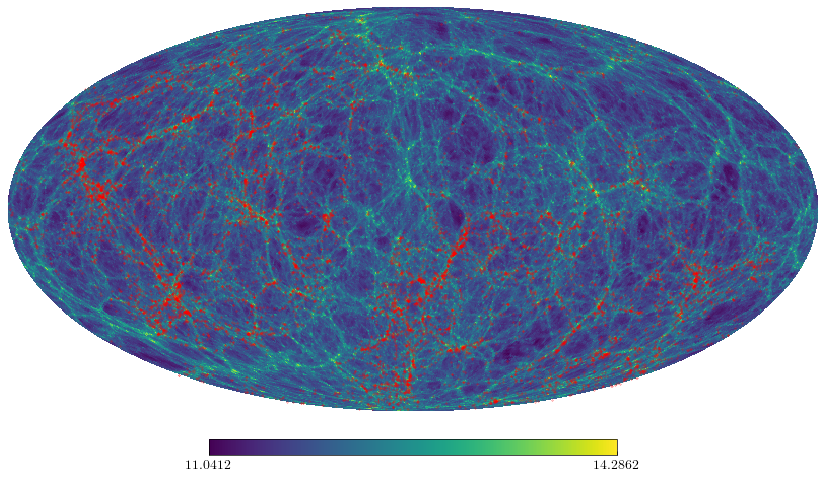

In [30]:
# delete_disk_caches_for_function("_plot_sky_projected_density")
plot_sky_projected_density(15517, "csiborg2_main", 1024, 128, "SPH", dmin=100,
                           dmax=125, survey_name="2M++", to_save=False)
# plt.savefig("test.png", dpi=300)